In [5]:
!aws s3 ls --human-readable --summarize s3://sagemaker-us-west-2-687912291502/dreambooth/trained_models/pytorch-training-2022-12-13-11-41-51-933/output/model.tar.gz

2022-12-13 13:21:56    3.6 GiB model.tar.gz

Total Objects: 1
   Total Size: 3.6 GiB


In [33]:
import sagemaker
import json
import io
from PIL import Image
from sagemaker.async_inference import AsyncInferenceConfig
import boto3
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key

In [34]:
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name

In [35]:
!rm -rf sourcedir.tar.gz && tar czvf sourcedir.tar.gz ./inference/dreambooth_inference.py ./inference/requirements.txt
source_dir = 's3://{0}/{1}/source/'.format(bucket, 'stablediffusion_dreambooth')
!aws s3 cp sourcedir.tar.gz $source_dir
source_dir = '{0}sourcedir.tar.gz'.format(source_dir)
!rm -f sourcedir.tar.gz

!touch dummy
!tar czvf model.tar.gz dummy
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion_dreambooth')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion_dreambooth')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

./inference/dreambooth_inference.py
./inference/requirements.txt
upload: ./sourcedir.tar.gz to s3://sagemaker-ap-southeast-1-687912291502/stablediffusion_dreambooth/source/sourcedir.tar.gz
dummy
upload: ./model.tar.gz to s3://sagemaker-ap-southeast-1-687912291502/stablediffusion_dreambooth/assets/model.tar.gz


In [36]:
model_name = None
entry_point = 'dreambooth_inference.py'
framework_version = '1.12'
py_version = 'py38'
async_config = AsyncInferenceConfig(output_path='s3://{0}/{1}/asyncinvoke/out/'.format(bucket, 'stablediffusion_dreambooth'))
model_environment = {
    'SAGEMAKER_MODEL_SERVER_TIMEOUT':'1200', 
    'SAGEMAKER_MODEL_SERVER_WORKERS': '1', 
    'model_name':'dreambooth_fine_tuned',
    #'model_path':'s3://sagemaker-us-west-2-687912291502/pytorch-training-2022-12-15-15-51-53-090/output/model.tar.gz'
    #'model_path': 's3://sagemaker-us-west-2-687912291502/dreambooth/trained_models/pytorch-training-2022-12-13-11-41-51-933/output/model.tar.gz'
    #'model_path':'s3://sagemaker-us-west-2-687912291502/dreambooth/trained_models/pytorch-training-2022-12-11-13-31-05-494/output/model.tar.gz'
    'model_path':'s3://sagemaker-ap-southeast-1-687912291502/dreambooth-finetuning-v3-2023-02-28-13-23-42-549/output/model.tar.gz'
    #'model_path':'s3://sagemaker-us-west-2-687912291502/dreambooth/trained_models/pytorch-training-2022-12-11-07-49-34-023/output/model.tar.gz'
}

In [47]:
from sagemaker.pytorch.model import PyTorchModel
model = PyTorchModel(
    model_data = model_data,
    entry_point = entry_point,
    #source_dir = source_dir,
    source_dir = "./inference/",
    role = role,
    framework_version = framework_version, 
    py_version = py_version,
    env = model_environment
)

In [48]:
instance_type = 'ml.g4dn.2xlarge'
instance_count = 1
predictor = model.deploy(
    instance_type = instance_type, 
    async_inference_config = async_config,
    initial_instance_count = instance_count,
    serializer = JSONSerializer(),
    deserializer = JSONDeserializer()
)

------------!

In [49]:
from sagemaker.async_inference.waiter_config import WaiterConfig
inputs = {
    'inputs': {"prompt": "Erwin Rommel at the Eiffel Tower in Paris "}
}
response = predictor.predict_async(inputs)
print(f"Response object: {response}")
print(f"Response output path: {response.output_path}")
print("Start Polling to get response:")

import time
start = time.time()

config = WaiterConfig(
  max_attempts=10000, #  number of attempts
  delay=10 #  time in seconds to wait between attempts
  )

response.get_result(config)

print(f"Time taken: {time.time() - start}s")

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f7609b6b2d0>
Response output path: s3://sagemaker-ap-southeast-1-687912291502/stablediffusion_dreambooth/asyncinvoke/out/886bb108-6ae6-48bc-bd0f-4bdfbb553fa1.out
Start Polling to get response:
Time taken: 10.11959719657898s


['s3://sagemaker-ap-southeast-1-687912291502/stablediffusion_dreambooth/invoke/images/7379b459-ad42-4323-94ce-20c5cfb99e42.jpg', 's3://sagemaker-ap-southeast-1-687912291502/stablediffusion_dreambooth/invoke/images/ffbfdf3f-045b-4ccf-b30b-0378a0053b5f.jpg', 's3://sagemaker-ap-southeast-1-687912291502/stablediffusion_dreambooth/invoke/images/aff9c521-59e1-4efe-8683-775f5125517a.jpg', 's3://sagemaker-ap-southeast-1-687912291502/stablediffusion_dreambooth/invoke/images/3f6d5d78-d88c-426a-875a-81f96f878d87.jpg', 's3://sagemaker-ap-southeast-1-687912291502/stablediffusion_dreambooth/invoke/images/23723051-ed9f-41e1-8ba1-d6e6ea956529.jpg', 's3://sagemaker-ap-southeast-1-687912291502/stablediffusion_dreambooth/invoke/images/da9c85be-7219-42f6-88cd-3ba147bac387.jpg']


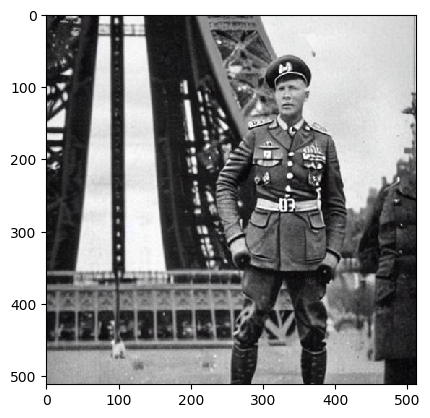

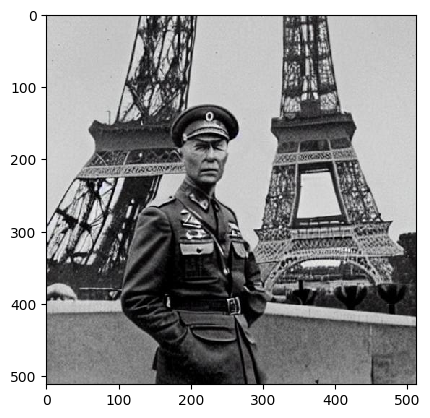

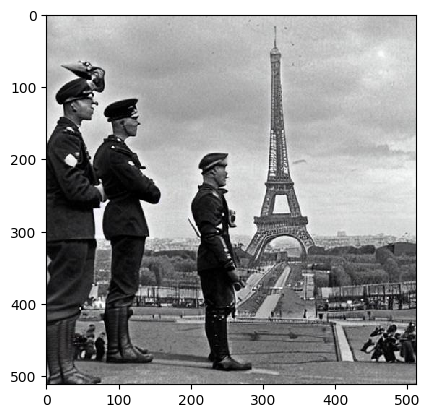

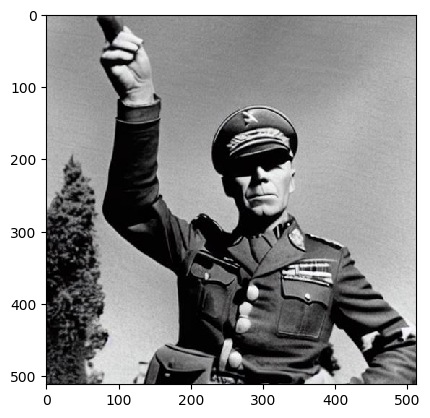

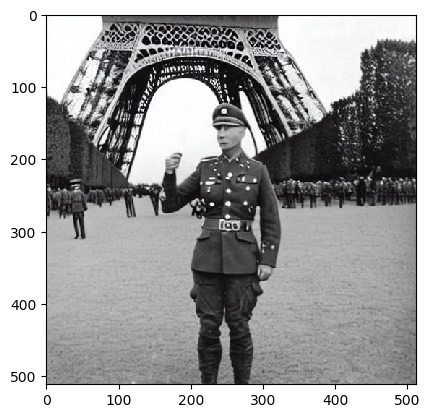

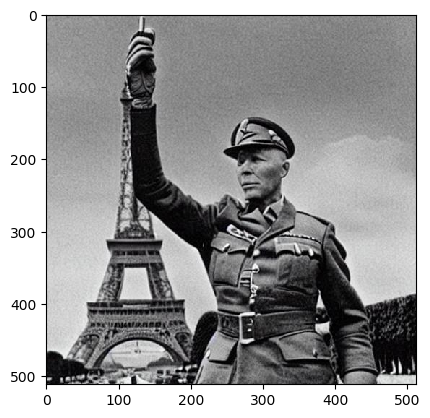

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F760A0E5090>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F764CEBAED0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F764CEA3390>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F764CFE7390>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F764CFCE950>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F764CF4B950>]


In [44]:
import traceback
import matplotlib.pyplot as plt


s3_client=boto3.resource('s3')

def display_images(images=None,columns=3, width=100, height=100):
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

try:
    bucket, key = get_bucket_and_key(response.output_path)
    obj = s3_client.Object(bucket, key)
    body = obj.get()['Body'].read().decode('utf-8') 
    predictions = json.loads(body)['result']
    print(predictions)
    images=[]
    for prediction in predictions:
        bucket, key = get_bucket_and_key(prediction)
        obj = s3_client.Object(bucket, key)
        bytes = obj.get()['Body'].read()
        image = Image.open(io.BytesIO(bytes))
        plt.imshow(image)
        plt.show()
        images.append(image)
    print(images)
    #display_images(images)
except Exception as e:
    traceback.print_exc()
    print(e)

In [ ]:
import boto3

aws_region='us-west-2'
endpoint_names=[
'pytorch-inference-2023-03-01-01-15-57-517',
'pytorch-inference-2022-12-16-06-06-51-066',
'pytorch-inference-2022-12-16-06-20-07-962']
for endpoint in endpoint_names:
    sagemaker_client = boto3.client('sagemaker', region_name=aws_region)
    sagemaker_client.delete_endpoint(EndpointName=endpoint)